In [5]:
from ipynb.fs.defs.DataLoader import data_loader
from ipynb.fs.defs.DataLoader import driver_classifier_TTC
import numpy as np
import math
import scipy.io as sio
import matplotlib.pyplot as plt

In [1]:
#Calibrated parameters value.

tau = 0.1
teta = 1.4640166666666665
a_n = 3.11665
Vn = 22.273275
b_n = -4.1299
b_spe = -3.0998916666666667
s_n = 2.5169416666666664

In [1]:
def Gipps_model(car_fol_id, a_n, b_n, s_n, Vn, b_spe, theta):

    i = car_fol_id
    j = np.random.randint(403)
    X_train, y_train, X_test, y_test, df, df_test, LeaderSpeed = data_loader(i, j, False, 50, False, normalize = False)
    
    n_collisions = 0
    
    ########################## Time definition #########################################

    Time_len = len(df.values) #Time length for the selected CF trajectory to reproduce. 
    T = [x for x in range(Time_len)] #Time array for the result plotting.

    Data = df.values 

    ########################## Gipps' model parameters #################################
    
    #tau = 1.3445
    #theta = 0.8918166666666666
    #a_n = 3.2930749999999995
    #Vn = 20.918841666666662
    #b_n = 4.150316666666666
    #b_spe = 2.285483333333333
    #s_n = 1.8169916666666666


    ########################### Definition of the required vehicles' dynamics (space, speed, and acceleration) ###########

    #The speed of the leading vehicle is described in the "LeaderSpeed" array

    #Acceleration of the leading vehicle
    LeaderAccel = np.zeros(Time_len)
    LeaderAccel[1] = (LeaderSpeed[1] - LeaderSpeed[0])/0.1
    LeaderAccel[0] = LeaderAccel[1]

    for i in range(1, Time_len-1):
        LeaderAccel[i+1] = (LeaderSpeed[i+1] - LeaderSpeed[i])/0.1


    #Space of the leading vehicle.
    LeaderSpace = np.zeros(Time_len)
    #LeaderSpace[1] = Data[0,0] + Data[0,2]*0.1  # The position of the leader vehicle at 0s
    #LeaderSpace[0] = LeaderSpace[1] - LeaderSpeed[0]*0.1

    LeaderSpace[0] = Data[0,0] + 7.5


    for i in range(Time_len-1):
        LeaderSpace[i+1] = LeaderSpace[i] + LeaderSpeed[i]*0.1


    # Space, speed, and acceleration of the following vehicle.
    FollowerSpace = np.zeros(Time_len)
    FollowerAccel = np.zeros(Time_len)
    FollowerSpeed = np.zeros(Time_len)

    FollowerSpace[0] = Data[0,0]
    FollowerAccel[0] = Data[0,3]
    #FollowerSpeed[0] = Data[0,1]
    FollowerSpeed[0] = LeaderSpeed[0]

    s = np.zeros(Time_len)

    v_free = np.zeros(Time_len)
    v_cf = np.zeros(Time_len)

    ############################ Computation of the follower's speed according to Gipps' formulation ###################

    for i in range(Time_len-1):

        # Calculate the distance between the two vehicles.
        s[i] = LeaderSpace[i] - FollowerSpace[i]

        if LeaderSpeed[i] < 0.0:
            LeaderSpeed[i] = 0.0001

        # Calculate the two required type of speed. 

        v_free[i] = FollowerSpeed[i] + 2.5*a_n*0.1*(1 - FollowerSpeed[i]/Vn)*np.sqrt(0.025 + FollowerSpeed[i]/Vn)

        v_cf[i] = b_n*(0.05 + theta) + np.sqrt(b_n*b_n*(0.05 + theta)**2 - b_n*(2*(LeaderSpace[i] -s_n -FollowerSpace[i]) -FollowerSpeed[i]*0.1 -(LeaderSpeed[i]**2)/b_spe))


        # Calculate the speed of the following vehicle. 
        FollowerSpeed[i+1] = min(v_free[i], v_cf[i])

        # Calculate the acceleration of the following vehicle
        FollowerAccel[i+1] = (FollowerSpeed[i+1] - FollowerSpeed[i])/0.1

        # Calculate the space of the following vehicle.
        FollowerSpace[i+1] = FollowerSpace[i] + FollowerSpeed[i]*0.1 

    #Last time step space gap between vehicles.  
    s[Time_len-1] = LeaderSpace[Time_len-1] - FollowerSpace[Time_len-1]
    
    if s[Time_len-1] < 0:
        n_collisions += 1
    
    # calculate the features for the reward.
    
    isCollision = 0
    TTC_threshold=4.001

    penalty = 100

    if s[i] < 0:
        isCollision = 1

    jerk = (FollowerAccel[i+1] - FollowerAccel[i]) / 0.1
    hdw = s[i] / FollowerSpeed[i]
    TTC = -s[i]/(Data[i][2])  # negative sign because of relative speed sign


    fJerk = -(jerk ** 2)/3600   # the maximum range is change from -3 to 3 in 0.1 s, then the jerk = 60


    if TTC >= 0 and TTC <= TTC_threshold:
        fTTC = np.log(TTC/TTC_threshold) 
    else:
        fTTC = 0

    mu = 0.422618  
    sigma = 0.43659
    if hdw <= 0:
        fHdw = -1
    else:
        fHdw = (np.exp(-(np.log(hdw) - mu) ** 2 / (2 * sigma ** 2)) / (hdw * sigma * np.sqrt(2 * np.pi)))



    #NRMSE(Spacing) reward feature. 
    def NRMSE(TrueSpace, SimSpace):

        if TrueSpace <= 0:
            TrueSpace = 0.00001

        if SimSpace <= 0:
            SimSpace = 0.00001

        MSE = (TrueSpace - SimSpace)**2
        RMSE = np.sqrt(MSE)
        NRMSE = RMSE/np.sqrt(TrueSpace**2)

        return NRMSE
    
    def RMSE(TrueSpace, SimSpace):

        if TrueSpace <= 0:
            TrueSpace = 0.00001

        if SimSpace <= 0:
            SimSpace = 0.00001

        MSE = (TrueSpace - SimSpace)**2
        RMSE = np.sqrt(MSE)

        return RMSE

    fRMSE = RMSE(Data[i][0], s[i])

    fNRMSE = - NRMSE(Data[i][0], s[i])
    
    
    # calculate the reward
    reward = fJerk + fTTC + fHdw + fNRMSE - penalty * isCollision

    reward /= Time_len-1
    
    LeaderSpeed = np.delete(LeaderSpeed, -1)
    
    return reward, -fNRMSE, fRMSE, fJerk, fHdw, fTTC, FollowerAccel, car_fol_id, LeaderSpeed, FollowerSpeed, s, FollowerSpace, LeaderSpace, n_collisions

In [6]:
df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()

In [7]:
len(aggressive_drivers)

109

In [8]:
len(timid_drivers)

112

In [9]:
#Effectively generate the trajectories using Gipps model.

tau = 0.1
theta = 1.4640166666666665
a_n = 3.11665
Vn = 22.273275
b_n = -4.1299
b_spe = -3.0998916666666667
s_n = 2.5169416666666664


from tqdm import tqdm

df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()


episode_rewards = []
safety_scores = []
comfort_scores = []
efficiency_scores = []
NRMSE_scores = []
RMSE_score = []
car_fol_ids = []
sim_data = []
sim_data2 = []

inds_done = []


for j in tqdm(timid_drivers): #Choose which driver group to use.
            
    reward, fNRMSE, fRMSE, fJerk, fHdw, fTTC, FollowerAccel, car_fol_id, LeaderSpeed, FollowerSpeed, s, FollowerSpace, LeaderSpace, n_collisions = Gipps_model(j, a_n, b_n, s_n, Vn, b_spe, theta)

    episode_rewards.append(reward)
    safety_scores.append(fTTC)
    comfort_scores.append(fJerk)
    efficiency_scores.append(fHdw)
    NRMSE_scores.append(-fNRMSE)
    RMSE_score.append(fRMSE)
    car_fol_ids.append(car_fol_id)


    sim_data.append(np.vstack((LeaderSpeed, FollowerSpeed, s)).T)
    sim_data2.append(np.vstack((LeaderSpace, FollowerSpace)).T)
                            
                        


100%|██████████| 112/112 [00:08<00:00, 13.23it/s]


In [10]:
print(n_collisions)

0


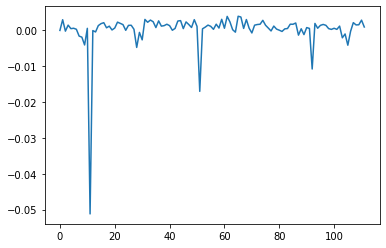

In [11]:
plt.plot(episode_rewards)

In [12]:
print(round(np.mean(episode_rewards),4),"+/-",round(np.std(episode_rewards),4))

0.0001 +/- 0.0055


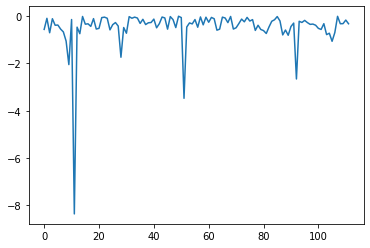

In [13]:
plt.plot(NRMSE_scores)

In [14]:
print(round(-np.mean(NRMSE_scores),4),"+/-",round(np.std(NRMSE_scores),4))

0.4833 +/- 0.8887


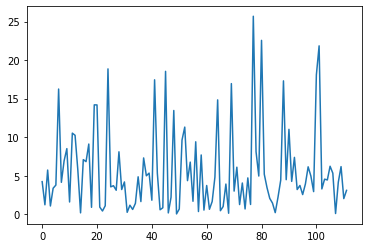

In [15]:
plt.plot(RMSE_score)

In [16]:
print(round(np.mean(RMSE_score),4),"+/-",round(np.std(RMSE_score),4))

5.5705 +/- 5.4836


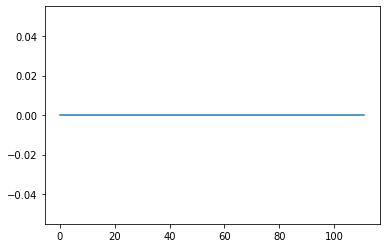

In [17]:
plt.plot(safety_scores)

In [18]:
print(round(np.mean(safety_scores),4),"+/-",round(np.std(safety_scores),4))

0.0 +/- 0.0


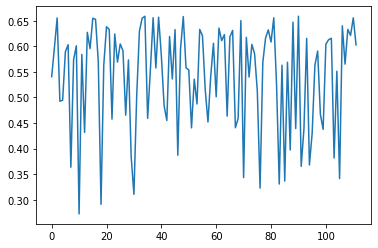

In [19]:
plt.plot(efficiency_scores)

In [20]:
print(round(np.mean(efficiency_scores),4),"+/-",round(np.std(efficiency_scores),4))

0.5413 +/- 0.1003


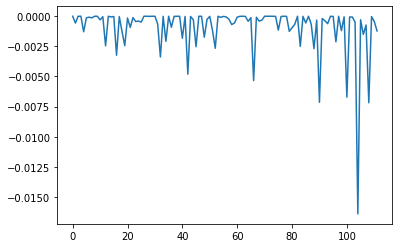

In [21]:
plt.plot(comfort_scores)

In [22]:
print(round(np.mean(comfort_scores),4),"+/-",round(np.std(comfort_scores),4))

-0.0009 +/- 0.0021


In [23]:
#Functions to determine the trajectories associated with the best (and worst) reward scores.

def Find_best_trajs(episode_score):
    
    L = len(episode_score)
    best_trajs = [[-np.inf,0, 0],[-np.inf,1, 1], [-np.inf,2, 2], [-np.inf,3, 3],[-np.inf,4, 4],
                        [-np.inf,5, 5],[-np.inf,6, 6],[-np.inf,7, 7],[-np.inf,8, 8],[-np.inf,9, 9]]
    
    
    for i in range(L):
        current_score = episode_score[i]
        current_ind = car_fol_ids[i] #indice of the trajectory associated with this score. 
        for j in range(10):
            if current_score > best_trajs[j][0]:
                best_trajs[j][0] = current_score
                best_trajs[j][1] = current_ind
                best_trajs[j][2] = i
                break
                
    best_cf_id = [x[1] for x in best_trajs]
    best_inds = [x[2] for x in best_trajs]
                
    return best_trajs, best_cf_id, best_inds

best_trajs, best_cf_id, best_inds = Find_best_trajs(episode_rewards)


def Find_worst_trajs(episode_score):
    
    L = len(episode_score)
    worst_trajs = [[np.inf,0, 0],[np.inf,1, 1], [np.inf,2, 2], [np.inf,3, 3],[np.inf,4, 4],
                        [np.inf,5, 5],[np.inf,6, 6],[np.inf,7, 7],[np.inf,8, 8],[np.inf,9, 9]]
    
    
    for i in range(L):
        current_score = episode_score[i]
        current_ind = car_fol_ids[i] #indice of the trajectory associated with this score. 
        for j in range(10):
            if current_score < worst_trajs[j][0]:
                worst_trajs[j][0] = current_score
                worst_trajs[j][1] = current_ind
                worst_trajs[j][2] = i
                break
                
    worst_cf_id = [x[1] for x in worst_trajs]
    worst_inds = [x[2] for x in worst_trajs]
                
    return worst_trajs, worst_cf_id, worst_inds

worst_trajs, worst_cf_id, worst_inds = Find_worst_trajs(episode_rewards)

In [24]:
best_trajs

[[0.0038739505460467336, 247, 65],
 [0.003657548633279047, 249, 66],
 [0.002954382635231856, 252, 68],
 [0.0027842522909527225, 400, 110],
 [0.002306481040950221, 233, 62],
 [0.002088046807009314, 390, 107],
 [0.0018715824649767105, 352, 93],
 [0.0016366742717181663, 308, 85],
 [0.0015878392886859581, 359, 96],
 [0.0014966398655675136, 399, 109]]

In [25]:
worst_trajs

[[-0.05121183856602055, 44, 11],
 [-0.017059145008586723, 189, 51],
 [-0.010829773066895282, 348, 92],
 [-0.0041999324118628814, 387, 105],
 [-0.001241620929249378, 336, 89],
 [-0.0010652588396939855, 385, 104],
 [-0.00033407521355675277, 389, 106],
 [0.00021855910256085906, 374, 101],
 [0.0004271454862187308, 368, 98],
 [0.0005202339635618769, 371, 100]]

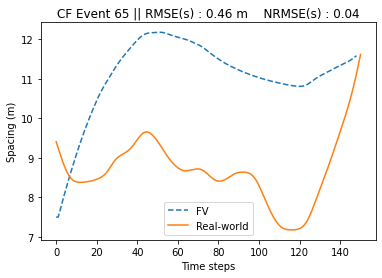

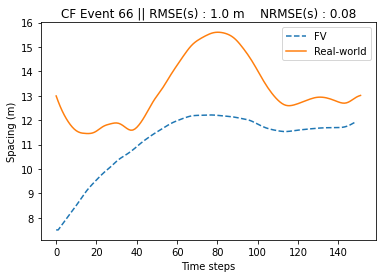

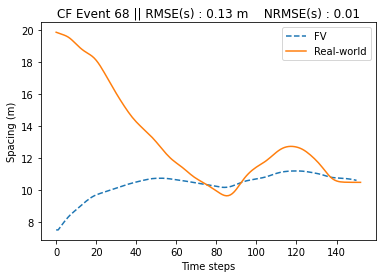

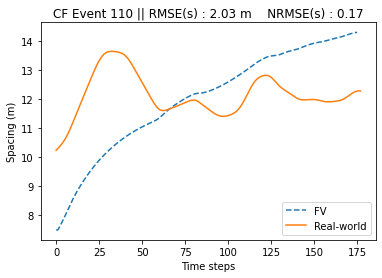

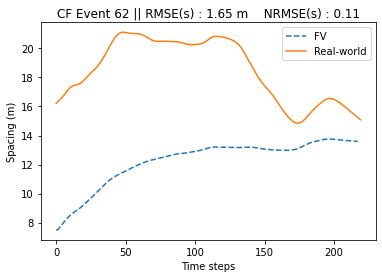

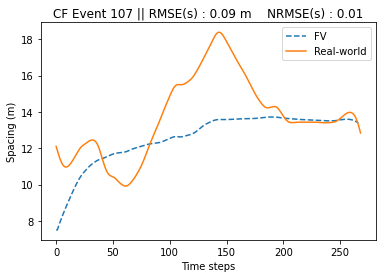

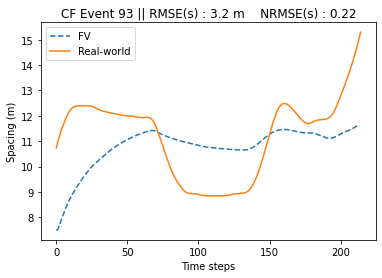

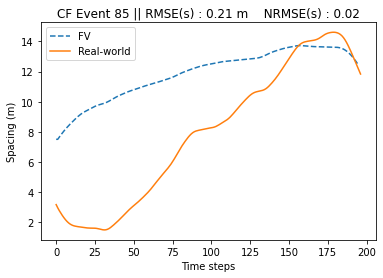

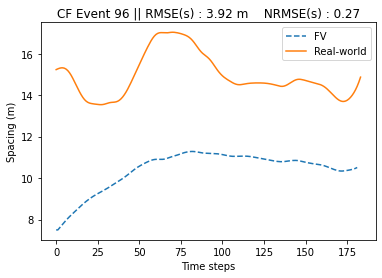

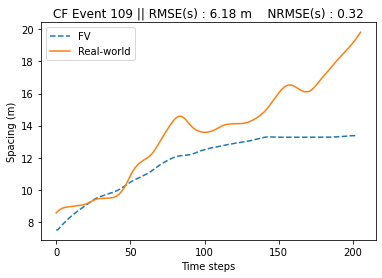

In [28]:
test = sio.loadmat('testSet.mat')['validationData']
train = sio.loadmat("trainSet.mat")["calibrationData"]

a = np.random.randint(403)
b = np.random.randint(403)
c = np.random.randint(403)

for i in best_inds:
    
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = train[j,0]
    
    score_traj = round(episode_rewards[i],4)
    nrmse_traj = -round(NRMSE_scores[i],2)
    rmse_traj = round(RMSE_score[i], 2)
    #score_ttc = round(score_s)
    
    plt.figure()
    plt.plot(data[:-1,2], '--', label = 'FV')
    plt.plot(real_data[:,0], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel('Spacing (m)')
    
    title = "CF Event " + str(i) + " || " + "RMSE(s) : " + str(rmse_traj) + " m " + "   NRMSE(s) : " + str(nrmse_traj)
    plt.title(title)

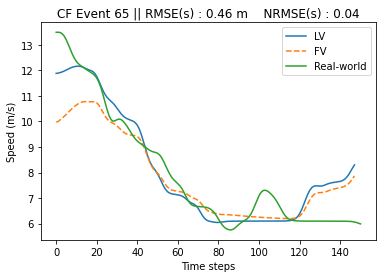

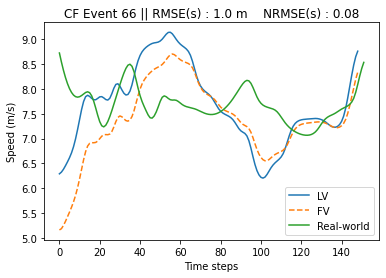

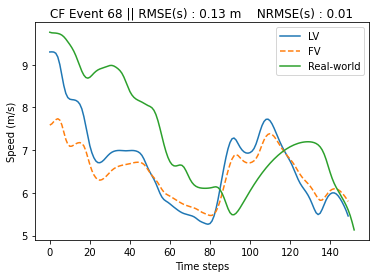

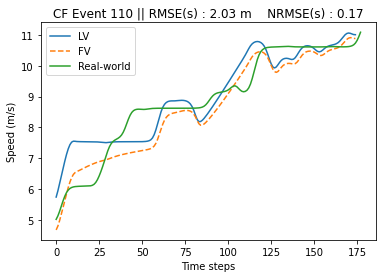

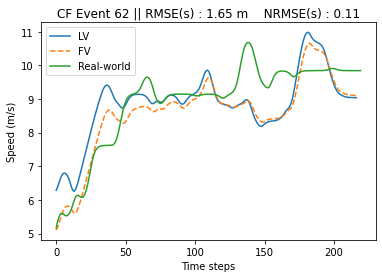

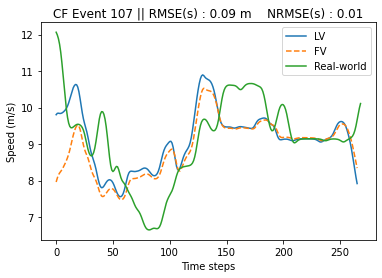

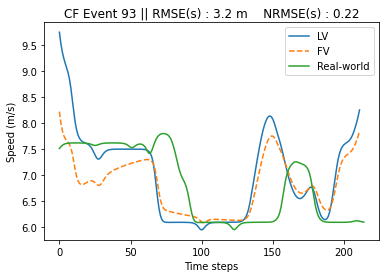

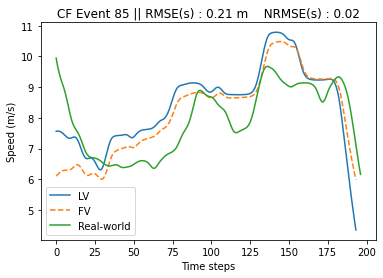

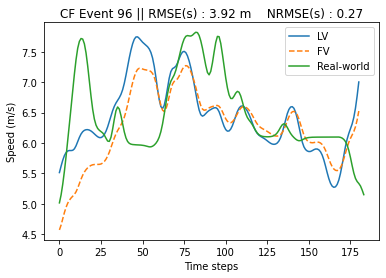

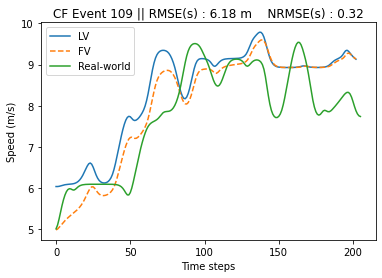

In [30]:
test = sio.loadmat('testSet.mat')['validationData']
train = sio.loadmat("trainSet.mat")["calibrationData"]

a = np.random.randint(403)
b = np.random.randint(403)
c = np.random.randint(403)

for i in best_inds:
    
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = train[j,0]
    
    score_traj = round(episode_rewards[i],4)
    nrmse_traj = -round(NRMSE_scores[i],2)
    rmse_traj = round(RMSE_score[i], 2)
    #score_ttc = round(score_s)
    
    plt.figure()
    plt.plot(data[1:-1,0], label = 'LV')
    plt.plot(data[1:-1,1], '--', label = 'FV')
    plt.plot(real_data[:,1], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel('Speed (m/s)')
    
    title = "CF Event " + str(i) + " || " + "RMSE(s) : " + str(rmse_traj) + " m " + "   NRMSE(s) : " + str(nrmse_traj)
    plt.title(title)

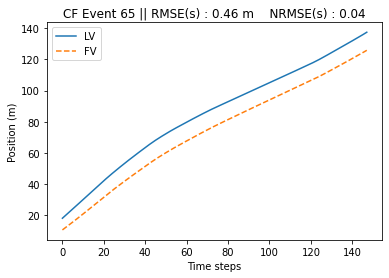

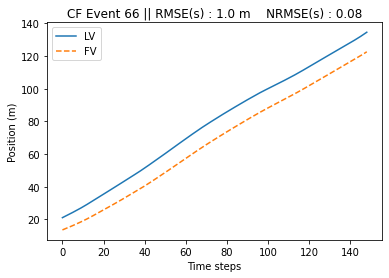

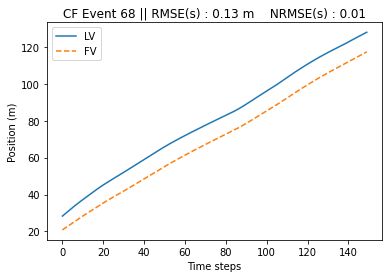

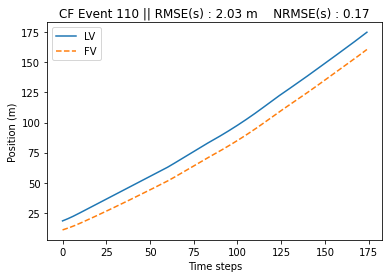

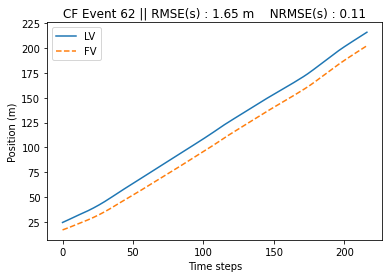

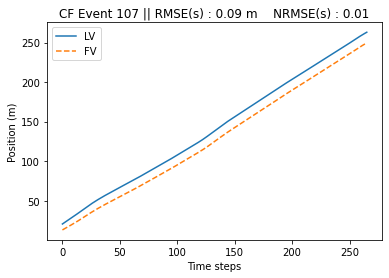

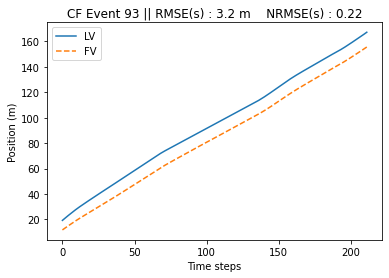

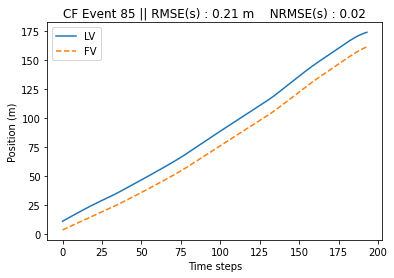

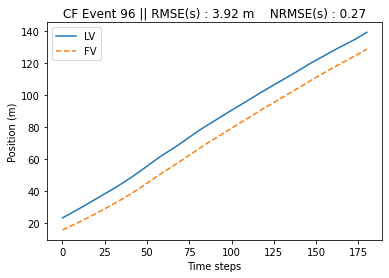

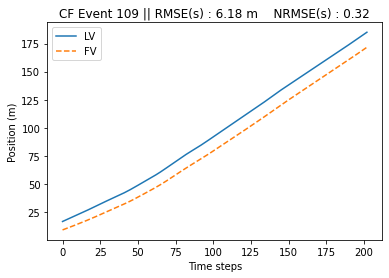

In [31]:
test = sio.loadmat('testSet.mat')['validationData']
train = sio.loadmat("trainSet.mat")["calibrationData"]

a = np.random.randint(403)
b = np.random.randint(403)
c = np.random.randint(403)

for i in best_inds:
    
    data = sim_data2[i]
    j = car_fol_ids[i]
    real_data = train[j,0]
    
    score_traj = round(episode_rewards[i],4)
    nrmse_traj = -round(NRMSE_scores[i],2)
    rmse_traj = round(RMSE_score[i], 2)
    #score_ttc = round(score_s)
    
    plt.figure()
    plt.plot(data[1:-1,0], label = 'LV')
    plt.plot(data[1:-1,1], '--', label = 'FV')
    #plt.plot(real_data[:,1], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel('Position (m)')
    
    title = "CF Event " + str(i) + " || " + "RMSE(s) : " + str(rmse_traj) + " m " + "   NRMSE(s) : " + str(nrmse_traj)
    plt.title(title)